<a href="https://colab.research.google.com/github/wilmi94/MasterThesis-AE-Codes/blob/main/Bobra2016_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sunpy

In [ ]:
pip install sunkit-instruments

In [ ]:
pip install mpld3

In [ ]:
pip install lime

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import pandas as pd
import scipy.stats
import requests
import urllib
import sunpy
from sunpy.time import parse_time
import sunkit_instruments
import json
from datetime import datetime as dt_obj
from datetime import timedelta
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sunpy.time import TimeRange
#import sunpy.instr.goes
import lime
import lime.lime_tabular
pd.set_option('display.max_rows', 500)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Step 1:  Gathering data for positive class

In [ ]:
# request the data
baseurl = "https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/FLR?"
t_start = "2010-05-01"
t_end = "2018-04-01"
url = baseurl+"startDate="+t_start+"&endDate="+t_end

# if there's no response at this time, print warning
response = requests.get(url)
if response.status_code != 200:
    print('cannot successfully get an http response')

In [ ]:
# read the data

print("Getting data from", url)
df = pd.read_json(url)

# select flares associated with a linked event (SEP or CME), and
# select only M or X-class flares
events_list = df.loc[df['classType'].str.contains(
    "M|X") & ~df['linkedEvents'].isnull()]

# drop all rows that don't satisfy the above conditions
events_list = events_list.reset_index(drop=True)

Getting data from https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/FLR?startDate=2010-05-01&endDate=2018-04-01


In [ ]:
# read the data

print("Getting data from", url)
df = pd.read_json(url)

# select flares associated with a linked event (SEP or CME), and
# select only M or X-class flares
events_list = df.loc[df['classType'].str.contains(
    "M|X") & ~df['linkedEvents'].isnull()]

# drop all rows that don't satisfy the above conditions
events_list = events_list.reset_index(drop=True)

Getting data from https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/FLR?startDate=2010-05-01&endDate=2018-04-01


In [ ]:
# drop the rows that aren't linked to CME events
for i in range(events_list.shape[0]):
    value = events_list.loc[i]['linkedEvents'][0]['activityID']
    if not "CME" in value:
        print(value, "not a CME, dropping row")
        events_list = events_list.drop([i])
events_list = events_list.reset_index(drop=True)

2011-08-09T08:40:00-SEP-001 not a CME, dropping row
2011-09-07T06:00:00-SEP-001 not a CME, dropping row
2011-09-24T11:50:00-SEP-001 not a CME, dropping row
2011-09-24T20:45:00-SEP-001 not a CME, dropping row
2012-07-09T01:20:00-SEP-001 not a CME, dropping row
2013-06-21T06:09:00-SEP-001 not a CME, dropping row
2015-03-06T19:20:00-SEP-001 not a CME, dropping row
2015-06-18T09:25:00-SEP-001 not a CME, dropping row
2015-06-21T20:35:00-SEP-001 not a CME, dropping row
2015-06-21T20:35:00-SEP-001 not a CME, dropping row


In [ ]:
def parse_tai_string(tstr):
    year = int(tstr[:4])
    month = int(tstr[5:7])
    day = int(tstr[8:10])
    hour = int(tstr[11:13])
    minute = int(tstr[14:16])
    return dt_obj(year, month, day, hour, minute)


for i in range(events_list.shape[0]):
    events_list['peakTime'].iloc[i] = parse_tai_string(
        events_list['peakTime'].iloc[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
def get_goes_event_list(timerange, goes_class_filter=None):
    """
    Retrieve list of flares detected by GOES within a given time range.

    Parameters
    ----------
    timerange : `sunpy.time.TimeRange`
        The time range to download the event list for.
    goes_class_filter: `str`, optional
        A string specifying a minimum GOES class for inclusion in the list,
        e.g., "M1", "X2".

    Returns
    -------
    `list`:
        A list of all the flares found for the given time range.
    """
    # Importing hek here to avoid calling code that relies on optional dependencies.
    import sunpy.net.attrs as attrs
    from sunpy.net import hek

    # use HEK module to search for GOES events
    client = hek.HEKClient()
    event_type = "FL"
    tstart = timerange.start
    tend = timerange.end

    # query the HEK for a list of events detected by the GOES instrument
    # between tstart and tend (using a GOES-class filter)
    if goes_class_filter:
        result = client.search(
            attrs.Time(tstart, tend),
            attrs.hek.EventType(event_type),
            attrs.hek.FL.GOESCls > goes_class_filter,
            attrs.hek.OBS.Observatory == "GOES",
        )
    else:
        result = client.search(
            attrs.Time(tstart, tend),
            attrs.hek.EventType(event_type),
            attrs.hek.OBS.Observatory == "GOES",
        )

    # want to condense the results of the query into a more manageable
    # dictionary
    # keep event data, start time, peak time, end time, GOES-class,
    # location, active region source (as per GOES list standard)
    # make this into a list of dictionaries
    goes_event_list = []

    for r in result:
        goes_event = {
            "event_date": parse_time(r["event_starttime"]).strftime("%Y-%m-%d"),
            "start_time": parse_time(r["event_starttime"]),
            "peak_time": parse_time(r["event_peaktime"]),
            "end_time": parse_time(r["event_endtime"]),
            "goes_class": str(r["fl_goescls"]),
            "goes_location": (r["event_coord1"], r["event_coord2"]),
            "noaa_active_region": r["ar_noaanum"],
        }
        goes_event_list.append(goes_event)

    return goes_event_list

In [ ]:
# Case 1: CME and Flare exist but NOAA active region number does not exist in DONKI database

number_of_donki_mistakes = 0  # count the number of DONKI mistakes
# create an empty array to hold row numbers to drop at the end
event_list_drops = []

for i in range(events_list.shape[0]):
    if (np.isnan(events_list.loc[i]['activeRegionNum'])):
        time = events_list['peakTime'].iloc[i]
        time_range = TimeRange(time, time)
        listofresults = get_goes_event_list(time_range, 'M1')
        if (listofresults[0]['noaa_active_region'] == 0):
            print(events_list.loc[i]['activeRegionNum'], events_list.loc[i]
                  ['classType'], "has no match in the GOES flare database ; dropping row.")
            event_list_drops.append(i)
            number_of_donki_mistakes += 1
            continue
        else:
            print("Missing NOAA number:", events_list['activeRegionNum'].iloc[i], events_list['classType'].iloc[i],
                  events_list['peakTime'].iloc[i], "should be", listofresults[0]['noaa_active_region'], "; changing now.")
            events_list['activeRegionNum'].iloc[i] = listofresults[0]['noaa_active_region']
            number_of_donki_mistakes += 1

# Drop the rows for which there is no active region number in both the DONKI and GOES flare databases
events_list = events_list.drop(event_list_drops)
events_list = events_list.reset_index(drop=True)
print('There are', number_of_donki_mistakes, 'DONKI mistakes so far.')

Missing NOAA number: nan X1.4 2011-09-22 11:01:00 should be 11302 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan X1.3 2012-03-07 01:14:00 should be 11430 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan M6.3 2012-03-09 03:53:00 should be 11429 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan M5.1 2012-05-17 01:47:00 should be 11476 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan X1.1 2012-07-06 23:08:00 should be 11515 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan M6.2 2012-07-28 20:56:00 should be 11532 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan M1.7 2012-11-08 02:23:00 should be 11611 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan M1.2 2013-03-15 06:58:00 should be 11692 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan X1.6 2013-05-13 02:17:00 should be 11748 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan X2.8 2013-05-13 16:05:00 should be 11748 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan X3.2 2013-05-14 01:11:00 should be 11748 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan X1.2 2013-05-15 01:48:00 should be 11748 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan M5.0 2013-05-22 13:38:00 should be 11745 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


nan M1.0 has no match in the GOES flare database ; dropping row.
nan M1.1 has no match in the GOES flare database ; dropping row.
Missing NOAA number: nan X4.9 2014-02-25 00:49:00 should be 11990 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


nan M1.4 has no match in the GOES flare database ; dropping row.
nan M2.2 has no match in the GOES flare database ; dropping row.
Missing NOAA number: nan M3.0 2015-03-06 04:57:00 should be 12297 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan M1.5 2015-03-06 08:15:00 should be 12297 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


nan M2.2 has no match in the GOES flare database ; dropping row.
Missing NOAA number: nan M2.8 2015-12-21 01:03:00 should be 12472 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Missing NOAA number: nan M1.1 2015-12-21 10:19:00 should be 12472 ; changing now.
There are 23 DONKI mistakes so far.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
# Grab all the data from the GOES database
time_range = TimeRange(t_start, t_end)
listofresults = get_goes_event_list(time_range, 'M1')
print('Grabbed all the GOES data; there are', len(listofresults), 'events.')

Grabbed all the GOES data; there are 793 events.


In [ ]:
# Case 2: NOAA active region number is wrong in DONKI database

# collect all the peak flares times in the NOAA database
peak_times_noaa = [item["peak_time"] for item in listofresults]

for i in range(events_list.shape[0]):
    # check if a particular DONKI flare peak time is also in the NOAA database
    peak_time_donki = events_list['peakTime'].iloc[i]
    if peak_time_donki in peak_times_noaa:
        index = peak_times_noaa.index(peak_time_donki)
    else:
        continue
    # ignore NOAA active region numbers equal to zero
    if (listofresults[index]['noaa_active_region'] == 0):
        continue
    # if yes, check if the DONKI and NOAA active region numbers match up for this peak time
    # if they don't, flag this peak time and replace the DONKI number with the NOAA number
    if (listofresults[index]['noaa_active_region'] != int(events_list['activeRegionNum'].iloc[i])):
        print('Messed up NOAA number:', int(events_list['activeRegionNum'].iloc[i]), events_list['classType'].iloc[i],
              events_list['peakTime'].iloc[i], "should be", listofresults[index]['noaa_active_region'], "; changing now.")
        events_list['activeRegionNum'].iloc[i] = listofresults[index]['noaa_active_region']
        number_of_donki_mistakes += 1
print('There are', number_of_donki_mistakes, 'DONKI mistakes so far.')

Messed up NOAA number: 11943 X1.2 2014-01-07 18:32:00 should be 11944 ; changing now.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Messed up NOAA number: 12051 M1.2 2014-05-07 16:29:00 should be 12055 ; changing now.
Messed up NOAA number: 12160 M1.4 2014-07-01 11:23:00 should be 12106 ; changing now.
Messed up NOAA number: 12282 M2.4 2015-02-09 23:35:00 should be 12280 ; changing now.
Messed up NOAA number: 12321 M1.1 2015-04-23 10:07:00 should be 12322 ; changing now.
Messed up NOAA number: 12565 M7.6 2016-07-23 05:16:00 should be 12567 ; changing now.
Messed up NOAA number: 12565 M5.5 2016-07-23 05:31:00 should be 12567 ; changing now.
There are 30 DONKI mistakes so far.


In [ ]:
# Case 3: The flare peak time is wrong in the DONKI database.

# create an empty array to hold row numbers to drop at the end
event_list_drops = []

active_region_numbers_noaa = [item["noaa_active_region"]
                              for item in listofresults]
flare_classes_noaa = [item["goes_class"] for item in listofresults]

for i in range(events_list.shape[0]):
    # check if a particular DONKI flare peak time is also in the NOAA database
    peak_time_donki = events_list['peakTime'].iloc[i]
    if not peak_time_donki in peak_times_noaa:
        active_region_number_donki = int(
            events_list['activeRegionNum'].iloc[i])
        flare_class_donki = events_list['classType'].iloc[i]
        flare_class_indices = [i for i, x in enumerate(
            flare_classes_noaa) if x == flare_class_donki]
        active_region_indices = [i for i, x in enumerate(
            active_region_numbers_noaa) if x == active_region_number_donki]
        common_indices = list(
            set(flare_class_indices).intersection(active_region_indices))
        if common_indices:
            print("Messed up time:", int(events_list['activeRegionNum'].iloc[i]), events_list['classType'].iloc[i],
                  events_list['peakTime'].iloc[i], "should be", peak_times_noaa[common_indices[0]], "; changing now.")
            events_list['peakTime'].iloc[i] = peak_times_noaa[common_indices[0]]
            number_of_donki_mistakes += 1
        if not common_indices:
            print("DONKI flare peak time",
                  events_list['peakTime'].iloc[i], "has no match; dropping row.")
            event_list_drops.append(i)
            number_of_donki_mistakes += 1

# Drop the rows for which the NOAA active region number and flare class associated with
# the messed-up flare peak time in the DONKI database has no match in the GOES flare database
events_list = events_list.drop(event_list_drops)
events_list = events_list.reset_index(drop=True)

# Create a list of corrected flare peak times
peak_times_donki = [events_list['peakTime'].iloc[i]
                    for i in range(events_list.shape[0])]

print('There are', number_of_donki_mistakes, 'DONKI mistakes so far.')

Messed up time: 11429 X1.1 2012-03-05 04:05:00 should be 2012-03-05T04:09:00.000 ; changing now.
DONKI flare peak time 2012-03-10 17:27:00 has no match; dropping row.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Messed up time: 11745 M5.0 2013-05-22 13:38:00 should be 2013-05-22T13:32:00.000 ; changing now.
DONKI flare peak time 2014-02-09 16:14:00 has no match; dropping row.
Messed up time: 12127 M1.5 2014-08-01 18:12:00 should be 2014-08-01T18:13:00.000 ; changing now.
Messed up time: 12146 M2.0 2014-08-25 15:10:00 should be 2014-08-25T15:11:00.000 ; changing now.
DONKI flare peak time 2014-09-03 13:53:00 has no match; dropping row.
DONKI flare peak time 2014-09-09 00:28:00 has no match; dropping row.
Messed up time: 12172 M2.3 2014-09-23 23:15:00 should be 2014-09-23T23:16:00.000 ; changing now.
Messed up time: 12242 X1.8 2014-12-20 00:24:00 should be 2014-12-20T00:28:00.000 ; changing now.
Messed up time: 12445 M1.9 2015-11-04 03:25:00 should be 2015-11-04T03:26:00.000 ; changing now.
Messed up time: 12473 M2.3 2015-01-02 00:10:00 should be 2016-01-02T00:11:00.000 ; changing now.
There are 42 DONKI mistakes so far.


In [ ]:
events_list

,flrID,instruments,beginTime,peakTime,endTime,classType,sourceLocation,activeRegionNum,linkedEvents,link
0,2011-02-15T01:44:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-15T01:44Z,2011-02-15 01:56:00,2011-02-15T02:06Z,X2.2,S20W10,11158.0,[{'activityID': '2011-02-15T02:25:00-CME-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
1,2011-02-24T07:23:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-24T07:23Z,2011-02-24 07:35:00,2011-02-24T07:42Z,M3.5,N14E87,11163.0,[{'activityID': '2011-02-24T08:00:00-CME-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
2,2011-03-07T13:44:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-03-07T13:44Z,2011-03-07 14:30:00,2011-03-07T15:08Z,M2.0,N11E21,11166.0,[{'activityID': '2011-03-07T14:40:00-CME-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
3,2011-03-07T19:43:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-03-07T19:43Z,2011-03-07 20:12:00,2011-03-07T21:40Z,M3.7,N30W48,11164.0,[{'activityID': '2011-03-07T20:12:00-CME-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
4,2011-03-08T03:37:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-03-08T03:37Z,2011-03-08 03:58:00,2011-03-08T04:20Z,M1.5,S21E72,11171.0,[{'activityID': '2011-03-08T05:00:00-CME-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
5,2011-06-07T06:16:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-06-07T06:16Z,2011-06-07 06:41:00,2011-06-07T06:59Z,M2.5,S22W53,11226.0,[{'activityID': '2011-06-07T06:50:00-CME-001'}...,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
6,2011-08-03T13:17:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-08-03T13:17Z,2011-08-03 13:48:00,2011-08-03T14:10Z,M6.0,N17W29,11261.0,[{'activityID': '2011-08-03T13:55:00-CME-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
7,2011-08-04T03:41:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-08-04T03:41Z,2011-08-04 03:57:00,2011-08-04T04:04Z,M9.3,N15W39,11261.0,[{'activityID': '2011-08-04T04:10:00-CME-001'}...,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
8,2011-09-07T22:32:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-09-07T22:32Z,2011-09-07 22:38:00,2011-09-07T22:44Z,X1.8,N15W31,11283.0,[{'activityID': '2011-09-07T23:24:00-CME-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
9,2011-09-22T10:29:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-09-22T10:29Z,2011-09-22 11:01:00,2011-09-22T11:44Z,X1.4,N09E89,11302.0,[{'activityID': '2011-09-22T11:24:00-CME-001'}...,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...


In [ ]:
answer = pd.read_csv(
    'http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt', sep=' ')

In [ ]:
timedelayvariable = 24

In [ ]:
t_rec = [(events_list['peakTime'].iloc[i] - timedelta(hours=timedelayvariable)
          ).strftime('%Y.%m.%d_%H:%M_TAI') for i in range(events_list.shape[0])]

In [ ]:
def get_the_jsoc_data(event_count, t_rec):
    """
    Parameters
    ----------
    event_count: number of events 
                 int

    t_rec:       list of times, one associated with each event in event_count
                 list of strings in JSOC format ('%Y.%m.%d_%H:%M_TAI')

    """

    catalog_data = []
    classification = []

    for i in range(event_count):

        print("=====", i, "=====")
        # next match NOAA_ARS to HARPNUM
        idx = answer[answer['NOAA_ARS'].str.contains(
            str(int(listofactiveregions[i])))]

        # if there's no HARPNUM, quit
        if (idx.empty == True):
            print('skip: there are no matching HARPNUMs for',
                  str(int(listofactiveregions[i])))
            continue

        # construct jsoc_info queries and query jsoc database; we are querying for 25 keywords
        url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_720s["+str(
            idx.HARPNUM.values[0])+"]["+t_rec[i]+"][? (CODEVER7 !~ '1.1 ') and (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]&op=rs_list&key=USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,MEANJZD,TOTUSJZ,SAVNCPP,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH"
        response = requests.get(url)

        # if there's no response at this time, quit
        if response.status_code != 200:
            print('skip: cannot successfully get an http response')
            continue

        # read the JSON output
        data = response.json()

        # if there are no data at this time, quit
        if data['count'] == 0:
            print('skip: there are no data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        # check to see if the active region is too close to the limb
        # we can compute the latitude of an active region in stonyhurst coordinates as follows:
        # latitude_stonyhurst = CRVAL1 - CRLN_OBS
        # for this we have to query the CEA series (but above we queried the other series as the CEA series does not have CODEVER5 in it)

        url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_cea_720s["+str(
            idx.HARPNUM.values[0])+"]["+t_rec[i]+"][? (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]&op=rs_list&key=CRVAL1,CRLN_OBS"
        response = requests.get(url)

        # if there's no response at this time, quit
        if response.status_code != 200:
            print('skip: failed to find CEA JSOC data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        # read the JSON output
        latitude_information = response.json()

        # if there are no data at this time, quit
        if latitude_information['count'] == 0:
            print('skip: there are no data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        CRVAL1 = float(latitude_information['keywords'][0]['values'][0])
        CRLN_OBS = float(latitude_information['keywords'][1]['values'][0])
        if (np.absolute(CRVAL1 - CRLN_OBS) > 70.0):
            print('skip: latitude is out of range for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        if ('MISSING' in str(data['keywords'])):
            print('skip: there are some missing keywords for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        print('accept NOAA Active Region number', str(int(
            listofactiveregions[i])), 'and HARPNUM', idx.HARPNUM.values[0], 'at time', t_rec[i])

        individual_flare_data = []
        for j in range(18):
            individual_flare_data.append(
                float(data['keywords'][j]['values'][0]))

        catalog_data.append(list(individual_flare_data))

        single_class_instance = [idx.HARPNUM.values[0], str(
            int(listofactiveregions[i])), listofgoesclasses[i], t_rec[i]]
        classification.append(single_class_instance)

    return catalog_data, classification

In [ ]:
listofactiveregions = list(events_list['activeRegionNum'].values.flatten())
listofgoesclasses = list(events_list['classType'].values.flatten())

In [ ]:
positive_result = get_the_jsoc_data(events_list.shape[0], t_rec)

===== 0 =====
accept NOAA Active Region number 11158 and HARPNUM 377 at time 2011.02.14_01:56_TAI
===== 1 =====
skip: there are no data for HARPNUM 392 at time 2011.02.23_07:35_TAI
===== 2 =====
accept NOAA Active Region number 11166 and HARPNUM 401 at time 2011.03.06_14:30_TAI
===== 3 =====
accept NOAA Active Region number 11164 and HARPNUM 393 at time 2011.03.06_20:12_TAI
===== 4 =====
skip: there are no data for HARPNUM 415 at time 2011.03.07_03:58_TAI
===== 5 =====
accept NOAA Active Region number 11226 and HARPNUM 637 at time 2011.06.06_06:41_TAI
===== 6 =====
accept NOAA Active Region number 11261 and HARPNUM 750 at time 2011.08.02_13:48_TAI
===== 7 =====
accept NOAA Active Region number 11261 and HARPNUM 750 at time 2011.08.03_03:57_TAI
===== 8 =====
accept NOAA Active Region number 11283 and HARPNUM 833 at time 2011.09.06_22:38_TAI
===== 9 =====
skip: there are no data for HARPNUM 892 at time 2011.09.21_11:01_TAI
===== 10 =====
skip: there are some missing keywords for HARPNUM 

In [ ]:
CME_data = positive_result[0]
positive_class = positive_result[1]
print("There are", len(CME_data), "CME events in the positive class.")

There are 79 CME events in the positive class.


# Step 2: Gathering data for negative class

In [ ]:
# select peak times that belong to both classes
all_peak_times = np.array([(listofresults[i]['peak_time'])
                           for i in range(len(listofresults))])

negative_class_possibilities = []
counter_positive = 0
counter_negative = 0
for i in range(len(listofresults)):
    this_peak_time = all_peak_times[i]
    if (this_peak_time in peak_times_donki):
        counter_positive += 1
    else:
        counter_negative += 1
        this_instance = [listofresults[i]['noaa_active_region'],
                         listofresults[i]['goes_class'], listofresults[i]['peak_time']]
        negative_class_possibilities.append(this_instance)
print("There are", counter_positive, "events in the positive class.")
print("There are", counter_negative, "events in the negative class.")

There are 142 events in the positive class.
There are 651 events in the negative class.


In [ ]:
t_rec = np.array([(negative_class_possibilities[i][2] - timedelta(hours=timedelayvariable)
                   ).strftime('%Y.%m.%d_%H:%M_TAI') for i in range(len(negative_class_possibilities))])

In [ ]:
listofactiveregions = list(
    negative_class_possibilities[i][0] for i in range(counter_negative))
listofgoesclasses = list(
    negative_class_possibilities[i][1] for i in range(counter_negative))

In [ ]:
negative_result = get_the_jsoc_data(counter_negative, t_rec)

===== 0 =====
accept NOAA Active Region number 11069 and HARPNUM 8 at time 2010.05.04_17:19_TAI
===== 1 =====
skip: there are no data for HARPNUM 54 at time 2010.06.11_00:57_TAI
===== 2 =====
accept NOAA Active Region number 11079 and HARPNUM 49 at time 2010.06.12_05:39_TAI
===== 3 =====
accept NOAA Active Region number 11093 and HARPNUM 115 at time 2010.08.06_18:24_TAI
===== 4 =====
accept NOAA Active Region number 11112 and HARPNUM 211 at time 2010.10.15_19:12_TAI
===== 5 =====
skip: latitude is out of range for HARPNUM 245 at time 2010.11.03_23:58_TAI
===== 6 =====
skip: latitude is out of range for HARPNUM 245 at time 2010.11.03_23:58_TAI
===== 7 =====
skip: latitude is out of range for HARPNUM 245 at time 2010.11.04_13:29_TAI
===== 8 =====
skip: latitude is out of range for HARPNUM 245 at time 2010.11.05_15:36_TAI
===== 9 =====
accept NOAA Active Region number 11149 and HARPNUM 345 at time 2011.01.27_01:03_TAI
===== 10 =====
accept NOAA Active Region number 11153 and HARPNUM 362 a

In [ ]:
no_CME_data = negative_result[0]
negative_class = negative_result[1]
print("There are", len(no_CME_data), "no-CME events in the negative class.")

There are 428 no-CME events in the negative class.


# Step 3: Feature Selection

In [ ]:
CME_data = np.array(CME_data)
no_CME_data = np.array(no_CME_data)

In [ ]:
def normalize_the_data(flare_data):
    flare_data = np.array(flare_data)
    n_elements = flare_data.shape[0]
    for j in range(flare_data.shape[1]):
        standard_deviation_of_this_feature = np.std(flare_data[:, j])
        median_of_this_feature = np.median(flare_data[:, j])
        for i in range(n_elements):
            flare_data[i, j] = (
                flare_data[i, j] - median_of_this_feature) / (standard_deviation_of_this_feature)
    return flare_data


no_CME_data = normalize_the_data(no_CME_data)
CME_data = normalize_the_data(CME_data)

print("There are", no_CME_data.shape[0], "flares with no associated CMEs.")
print("There are", CME_data.shape[0], "flares with associated CMEs.")

There are 428 flares with no associated CMEs.
There are 79 flares with associated CMEs.


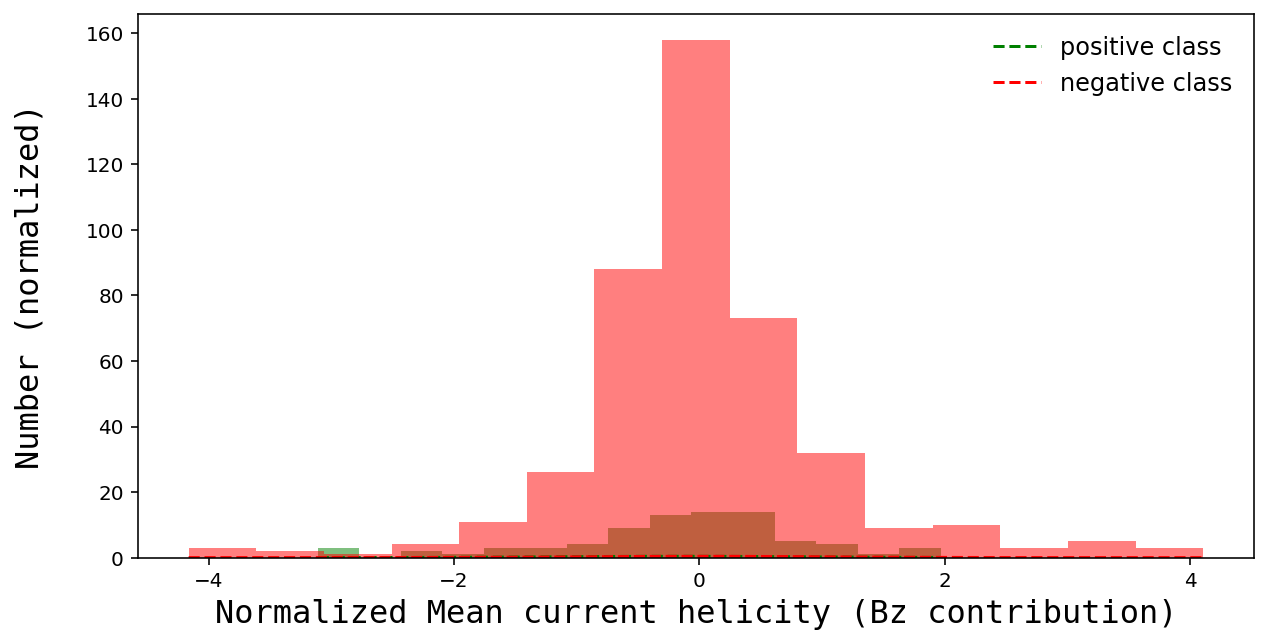

In [ ]:
sharps = ['Total unsigned flux', 'Mean gradient of total field',
          'Mean current helicity (Bz contribution)', 'Mean photospheric magnetic free energy',
          'Fraction of Area with Shear > 45 deg', 'Total unsigned current helicity',
          'Mean gradient of horizontal field', 'Mean characteristic twist parameter, alpha',
          'Mean angle of field from radial', 'Mean gradient of vertical field',
          'Mean vertical current density', 'Total unsigned vertical current',
          'Sum of the modulus of the net current per polarity',
          'Total photospheric magnetic free energy density', 'Mean shear angle',
          'Area of strong field pixels in the active region', 'Sum of flux near polarity inversion line',
          'Absolute value of the net current helicity']

i = 2

# For the positive class (green)
mu_fl = np.mean(CME_data[:, i])
sigma_fl = np.std(CME_data[:, i])
num_bins = 15
n_fl, bins_fl, patches_fl = plt.hist(CME_data[:, i], num_bins, facecolor='green', alpha=0.5)
y_fl = scipy.stats.norm.pdf(bins_fl, mu_fl, sigma_fl)
plt.plot(bins_fl, y_fl, 'g--', label='positive class')

# For the negative class (red)
mu_nofl = np.mean(no_CME_data[:, i])
sigma_nofl = np.std(no_CME_data[:, i])
n_nofl, bins_nofl, patches_nofl = plt.hist(
    no_CME_data[:, i], num_bins, facecolor='red', alpha=0.5)
y_nofl = scipy.stats.norm.pdf(bins_nofl, mu_nofl, sigma_nofl)
plt.plot(bins_nofl, y_nofl, 'r--', label='negative class')

text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
plt.xlabel('Normalized '+sharps[i], **text_style)
plt.ylabel('Number (normalized)', labelpad=20, **text_style)
fig = plt.gcf()
fig.set_size_inches(10, 5)
fig.savefig('fscore_tmp.png', bbox_inches='tight')
legend = plt.legend(loc='upper right', fontsize=12, framealpha=0.0, title='')
legend.get_frame().set_linewidth(0.0)

In [ ]:
# import the feature selection method
from sklearn.feature_selection import SelectKBest, f_classif
# select the number of features
N_features = 18
Nfl = CME_data.shape[0]
Nnofl = no_CME_data.shape[0]
yfl = np.ones(Nfl)
ynofl = np.zeros(Nnofl)
# k is the number of features
selector = SelectKBest(f_classif, k=N_features)
selector.fit(np.concatenate((CME_data, no_CME_data), axis=0),
             np.concatenate((yfl, ynofl), axis=0))
scores = selector.scores_
print(scores)

[2.58434622e-01 1.80613220e+00 2.75720486e+00 2.68994023e+00
 8.06933033e-02 1.84214703e-03 1.39527704e+00 1.88377723e+00
 2.05723060e-01 4.43482174e-02 4.48382765e-01 6.65904291e-02
 1.00183089e-01 3.07320442e-04 9.57459834e-02 7.10721027e-04
 1.34756272e+00 2.57715104e-02]


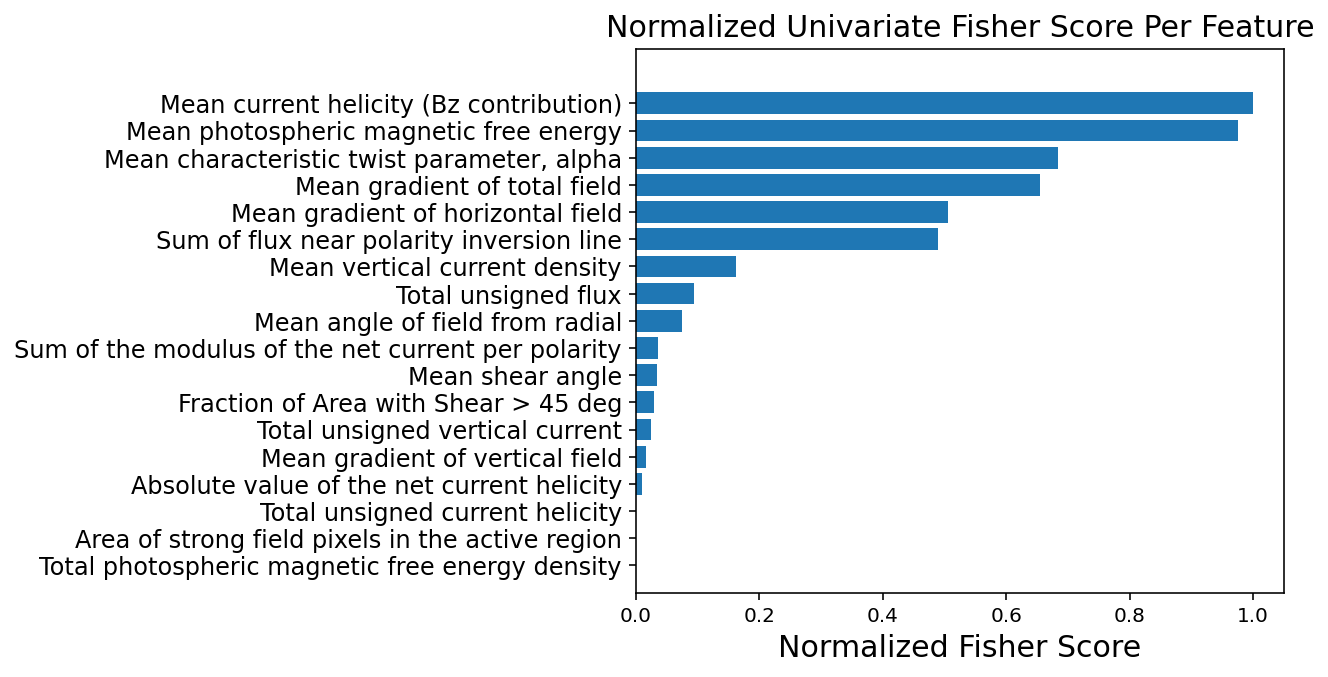

In [ ]:
plt.clf()
order = np.argsort(scores)
orderedsharps = [sharps[i] for i in order]
y_pos2 = np.arange(18)
plt.barh(y_pos2, sorted(scores/np.max(scores)))
plt.ylim((-1, 19))
plt.yticks(y_pos2, orderedsharps, fontsize=12)
plt.xlabel('Normalized Fisher Score', fontsize=15)
plt.title('Normalized Univariate Fisher Score Per Feature', fontsize=15)
plt.subplots_adjust(left=0.5, right=1.0)
fig = plt.gcf()
fig.set_size_inches(9, 5)
plt.show()

# Step 4 SVM

In [ ]:
number_of_examples = Nfl + Nnofl
C = 4.0
gamma = 0.075
class_weight = {1: 6.5}
clf = svm.SVC(C=C, gamma=gamma, kernel='rbf', class_weight=class_weight,
              cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)

# Step 5: Stratified k-folds cross-validation

In [ ]:
def confusion_table(pred, labels):
    """
    computes the number of TP, TN, FP, FN events given the arrays with predictions and true labels
    and returns the true skill score

    Args:
    pred: np array with predictions (1 for flare, 0 for nonflare)
    labels: np array with true labels (1 for flare, 0 for nonflare)

    Returns: true negative, false positive, true positive, false negative
    """
    Nobs = len(pred)
    TN = 0.
    TP = 0.
    FP = 0.
    FN = 0.
    for i in range(Nobs):
        if (pred[i] == 0 and labels[i] == 0):
            TN += 1
        elif (pred[i] == 1 and labels[i] == 0):
            FP += 1
        elif (pred[i] == 1 and labels[i] == 1):
            TP += 1
        elif (pred[i] == 0 and labels[i] == 1):
            FN += 1
        else:
            print("Error! Observation could not be classified.")
    return TN, FP, TP, FN

In [ ]:
# lists to hold the TSS and standard deviation of the TSS
array_of_avg_TSS = np.ndarray([50])
array_of_std_TSS = np.ndarray([50])

# xdata are the examples
# ydata are the labels
xdata = np.concatenate((CME_data, no_CME_data), axis=0)
ydata = np.concatenate((np.ones(Nfl), np.zeros(Nnofl)), axis=0)

# mdata contain metadata about the active region that will be useful
# when we interpret the results using LIME
mdata = np.concatenate((positive_class, negative_class), axis=0)

# compute the TSS for a variety of k ranging from 2 to 52
# this is to see how the TSS varies as a function of k, and to test if k=10 really makes sense
for k in range(2, 52):
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    these_TSS_for_this_k = []
    for train_index, test_index in skf.split(xdata, ydata):
        # xtrain are the examples in the training set
        xtrain = xdata[train_index]
        # ytrain are the labels in the training set
        ytrain = ydata[train_index]
        # xtest are the examples in the testing set
        xtest = xdata[test_index]
        ytest = ydata[test_index]    # ytest are the labels in the testing set
        # metadata useful for interpreting with LIME
        mtrain = mdata[train_index]
        # metadata useful for interpreting with LIME
        mtest = mdata[test_index]
        clf.fit(xtrain, ytrain)
        TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
        if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
            these_TSS_for_this_k.append(np.nan)
            continue
        else:
            these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
    TSS_k = np.array(these_TSS_for_this_k)
    array_of_avg_TSS[k-2] = np.mean(TSS_k)
    array_of_std_TSS[k-2] = np.std(TSS_k)

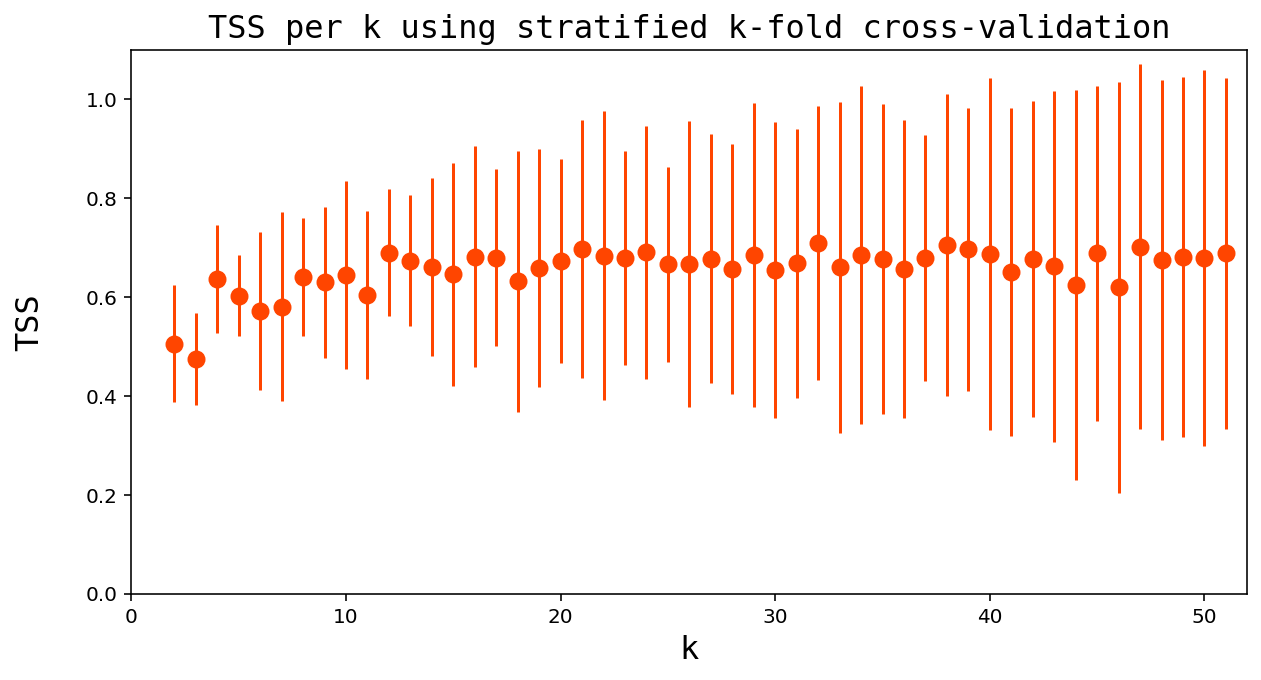

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))      # define the size of the figure
orangered = (1.0, 0.27, 0, 1.0)              # create an orange-red color
cornblue = (0.39, 0.58, 0.93, 1.0)           # create a cornflower-blue color

# define some style elements
marker_style_red = dict(linestyle='', markersize=8,
                        fillstyle='full', color=orangered, markeredgecolor=orangered)
marker_style_blue = dict(linestyle='', markersize=8,
                         fillstyle='full', color=cornblue, markeredgecolor=cornblue)
text_style = dict(fontsize=16, fontdict={'family': 'monospace'})

# ascribe the data to the axes
k = np.arange(50)+2
for i in range(50):
    if (array_of_avg_TSS[i] > array_of_std_TSS[i]):
        ax.errorbar(k[i], array_of_avg_TSS[i],
                    yerr=array_of_std_TSS[i], linestyle='', color=orangered)
        ax.plot(k[i], array_of_avg_TSS[i], 'o', **marker_style_red)
    if (array_of_avg_TSS[i] <= array_of_std_TSS[i]):
        ax.errorbar(k[i], array_of_avg_TSS[i],
                    yerr=array_of_std_TSS[i], linestyle='', color=cornblue)
        ax.plot(k[i], array_of_avg_TSS[i], 'o', **marker_style_blue)

# set plot limits
plt.xlim(xmax=52, xmin=0)
plt.ylim(ymax=1.1, ymin=0)

# label the axes and the plot
ax.set_xlabel('k', **text_style)
ax.set_ylabel('TSS', labelpad=20, **text_style)
plt.title(r'TSS per k using stratified k-fold cross-validation', **text_style)
fig = plt.gcf()
fig.set_size_inches(10, 5)

In [ ]:
print("The TSS equals", array_of_avg_TSS[9],
      "plus or minus", array_of_std_TSS[9], ".")

The TSS equals 0.6036704523546628 plus or minus 0.17038183543591534 .


# Addendum : Local Interpretable Model-Agnostic Explanations (LIME)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    xtrain, feature_names=sharps, class_names=['CME', 'no CME'], discretize_continuous=True)

In [ ]:
i = np.random.randint(0, xtest.shape[0])
exp = explainer.explain_instance(xtest[i], clf.predict_proba, num_features=8)

In [ ]:
print("Here is the prediction explanation for NOAA Active Region",
      mtest[i][1], "(HARPNUM ", mtest[i][0], "),\n which produced a", mtest[i][2], "class flare on", mtest[i][3], ".")
exp.show_in_notebook(show_table=False, show_all=False)

Here is the prediction explanation for NOAA Active Region 11263 (HARPNUM  753 ),
 which produced a X6.9 class flare on 2011.08.08_08:05_TAI .


In [ ]:
explained_list = exp.as_list()
for i in range(len(explained_list)):
    if (explained_list[i][1]) < 0:
        feature_sign = 'no CME'
    else:
        feature_sign = 'CME'
    print("The following condition:", explained_list[i][0], "\n predicts",
          feature_sign, "with a model weight of", abs(explained_list[i][1]), ".")

The following condition: Mean gradient of horizontal field <= -0.68 
 predicts CME with a model weight of 0.2606518846665072 .
The following condition: Mean gradient of total field <= -0.65 
 predicts no CME with a model weight of 0.22344600124836056 .
The following condition: Absolute value of the net current helicity > 0.69 
 predicts no CME with a model weight of 0.1617556442292695 .
The following condition: Mean current helicity (Bz contribution) > 0.43 
 predicts no CME with a model weight of 0.06906224241233175 .
The following condition: -0.40 < Total unsigned vertical current <= 0.00 
 predicts no CME with a model weight of 0.050758330243265065 .
The following condition: -0.74 < Mean photospheric magnetic free energy <= 0.01 
 predicts no CME with a model weight of 0.05033657882846116 .
The following condition: -0.40 < Total unsigned current helicity <= 0.01 
 predicts CME with a model weight of 0.04349448781481147 .
The following condition: Mean gradient of vertical field <= -0